Further analysis of TVDN features


In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from pyTVDN import TVDNDetect

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import itertools
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [14]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        ttest_res1 = mannwhitneyu(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
        tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                    f"{ttest_res1.pvalue:>6.3f}", 
                    f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    ttest_res1 = mannwhitneyu(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}Dementia vs HC", 
                f"{ttest_res1.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");


yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
yeo_7nets_ts = load_pkl(DATA_ROOT/"ad_ftd_hc_fmri_data_7nets.pkl");


labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);

num_rois = 246 # the BNA has 246 regions
num_sps = 321
ac_time = 485

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../data/ad_ftd_hc_fmri_data_7nets.pkl


485

In [8]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

# Extract TVDN

In [9]:
tvdn_paras = edict()
# these two are most influential
tvdn_paras.fct = 0.1
tvdn_paras.lamb = 5e-5
# r is moderately influential
tvdn_paras.r = 0.8
# not very important
tvdn_paras.Lmin = 5
tvdn_paras.MaxM = 20

tvdn_paras.kappas = np.linspace(1, 2, 1000)

In [10]:
def _run_fn(sub_ix, net_ix, ncpts):
    ts = yeo_7nets_ts[yeo_7nets_dict[net_ix]][sub_ix-1];
    det = TVDNDetect(Ymat=ts,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdn_7nets_res_MaxM20",
                     fName=f"sub_{sub_ix}_{yeo_7nets_dict[net_ix]}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     fct=tvdn_paras.fct, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    det()
    det.UpdateEcpts(ncpts)
    det.GetFeatures()
    return det


In [11]:
net_ix = 7 # only care about DMN

7

In [12]:
rks = np.array(load_pkl(RES_ROOT/f"tvdnMaxM20_ranks_{yeo_7nets_dict[net_ix]}.pkl"));
ecptss = load_pkl(RES_ROOT/f"tvdnMaxM20_ecptss_kp1647_{yeo_7nets_dict[net_ix]}.pkl")
ncpts = np.array([len(ecpts) for ecpts in ecptss]);

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ranks_Default.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Default.pkl


In [13]:
wUs = []
for sub_ix in trange(1, num_sps+1):
    det = _run_fn(sub_ix, net_ix, ncpts[sub_ix-1]);
    wU = det.curEigVecs @ np.array(det.curEigVals).T
    assert np.allclose(np.abs(wU.imag).sum(), 0)
    wU = wU.real;
    wUs.append(wU)

  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:27<00:00,  3.68it/s]


In [79]:
wUs_sub_idx = np.concatenate([(ncpt+1)*[sub_ix+1] for sub_ix, ncpt in enumerate(ncpts)]);
wUs_pool = np.concatenate(wUs, axis=1).T;

wUs_diag_lab = np.zeros_like(wUs_sub_idx)
for sub_ix in range(1, num_sps+1):
    wUs_diag_lab[wUs_sub_idx==sub_ix] = diag_labs[sub_ix-1]

In [150]:
_get_dwell = lambda ecpts: np.diff(np.concatenate([[0], ecpts, [235]]))*ac_time/235
dwells = [_get_dwell(ecpts) for ecpts in ecptss]; 

# Analysis

In [312]:
n_comps = 8
n_clus = 5

5

## PCA and Clustering

In [338]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_comps, random_state=0)
pca.fit(wUs_pool)
wUs_reduced = pca.transform(wUs_pool);
print(f"The explained var ratio is {pca.explained_variance_ratio_.sum():.3f}.")

The explained var ratio is 0.581.


In [339]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clus, random_state=0).fit(wUs_reduced)
wUs_clu_labs = kmeans.labels_
tb = pd.crosstab(kmeans.labels_, wUs_diag_lab)
tbn = tb.div(tb.sum(), axis=1);
tbn.columns = [diag_lab_mapping[ix] for ix in tbn.columns]
tbn

,AD,bvFTD,CBS,nfvPPA,svPPA,HC
row_0,,,,,,
0,0.212336,0.254682,0.158038,0.196507,0.173745,0.206667
1,0.178969,0.147940,0.215259,0.209607,0.249035,0.185926
2,0.175935,0.181648,0.209809,0.244541,0.158301,0.237037
3,0.238625,0.249064,0.179837,0.168122,0.202703,0.141481
4,0.194135,0.166667,0.237057,0.181223,0.216216,0.228889


In [336]:
map_vecs = pca.inverse_transform(kmeans.cluster_centers_);
for clu_ix in range(n_clus):
    vec = np.zeros(num_rois)
    vec[yeo_7nets_lab==7] = map_vecs[clu_ix]
    np.savetxt(MIDRES_ROOT/f"cluster_{clu_ix}_brainvec.txt", vec)

In [357]:
map_vecs[0].max()

6.543227256905674

In [340]:
def update_trans_ct(cur_trans_ct, vec):
    for ix in range(len(vec)-1):
        from_ = vec[ix]
        to_ = vec[ix+1]
        cur_trans_ct[from_, to_] += 1
    return cur_trans_ct

cur_trans_ct = np.zeros((n_clus, n_clus));

In [342]:
trans_ct = {}
for disease_ix in range(1, 7):
    cur_trans_ct = np.zeros((n_clus, n_clus));
    for sub_ix in (np.where(diag_labs == disease_ix)[0]+1):
        vec = wUs_clu_labs[wUs_sub_idx==sub_ix]
        update_trans_ct(cur_trans_ct, vec)
    trans_ct[disease_ix] = cur_trans_ct
    np.savetxt(MIDRES_ROOT/f"trans_mat_{diag_lab_mapping[disease_ix]}.txt", cur_trans_ct)

## Dwell time x cluster x Disease

In [343]:
dwells_pool = np.concatenate(dwells);

In [344]:
dwell_mat = np.zeros((n_clus, 6));
for clu_ix in range(n_clus):
    for grp_ix in range(1, 7):
        sel_idx = np.bitwise_and(wUs_diag_lab==grp_ix, wUs_clu_labs==clu_ix)
        dwell_mat[clu_ix, grp_ix-1] = np.sum(dwells_pool[sel_idx])

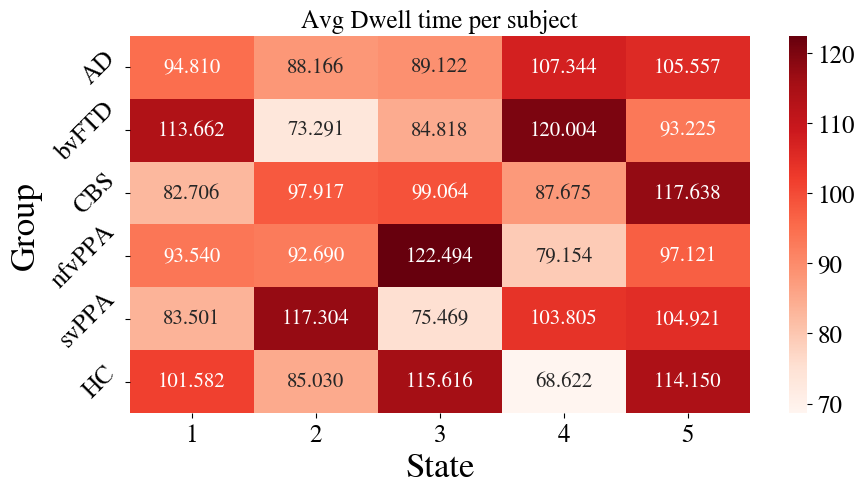

In [362]:
dwell_mat_persub = 485*dwell_mat/dwell_mat.sum(axis=0, keepdims=True);
sns.heatmap(dwell_mat_persub.T, annot=True, fmt=".3f", cmap="Reds")
plt.ylabel("Group")
plt.xlabel("State")
plt.title("Avg Dwell time per subject")
plt.yticks(np.arange(6)+0.5, [diag_lab_mapping[ix] for ix in range(1, 7)], rotation=45);
plt.xticks(np.arange(5)+0.5, np.arange(1, 6));

In [346]:
dwell_persub_perclu = np.zeros((num_sps, n_clus))
for sub_ix in range(1, num_sps+1):
    for clu_ix in range(n_clus):
        cur_idxs = np.bitwise_and(wUs_sub_idx==sub_ix, wUs_clu_labs==clu_ix)
        dwell_persub_perclu[sub_ix-1, clu_ix] = np.sum(dwells_pool[cur_idxs])
    

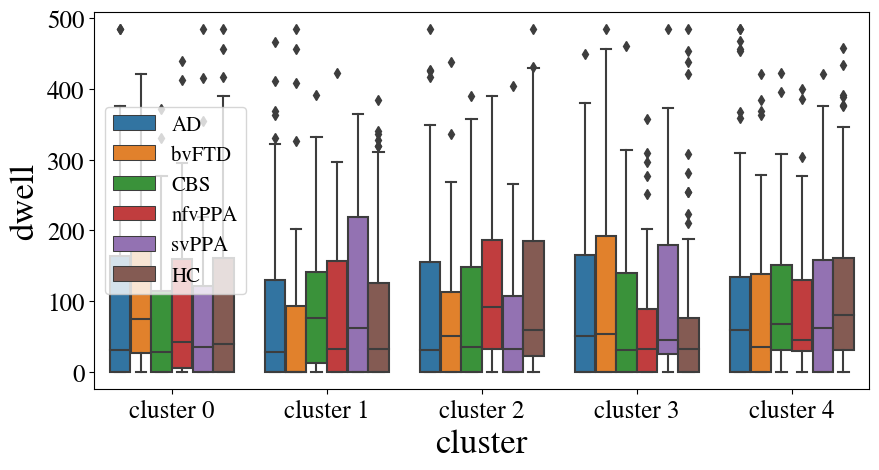

In [347]:
df = pd.DataFrame({
"dwell": dwell_persub_perclu.flatten(),
"cluster": [f"cluster {ix}" for ix in range(n_clus)] * num_sps,
"diag": np.repeat(diag_labs, n_clus)
    })
df["diag1"] = df["diag"].map(diag_lab_mapping)
sns.boxplot(data=df, x="cluster", y="dwell", hue="diag1", showfliers=1)
#plt.xlim([-1, 5])
plt.legend(fontsize=15)

In [348]:
for clu_ix in range(n_clus):
    vec1 = df[(df["diag1"] =="AD") & (df["cluster"]==f"cluster {clu_ix}")]["dwell"]
    vec2 = df[(df["diag1"] =="HC") & (df["cluster"]==f"cluster {clu_ix}")]["dwell"]
    test_res1 = scipy.stats.mannwhitneyu(vec1, vec2)
    test_res2 = scipy.stats.ttest_ind(vec1, vec2)
    print("-"*50)
    print(f"Cluster {clu_ix}")
    print(f"Non-param T test: pval {test_res1.pvalue:.3f}")
    print(f"T test: pval {test_res2.pvalue:.3f} (AD-Ctrl: {test_res2.statistic:.3f})")

--------------------------------------------------
Cluster 0
Non-param T test: pval 0.430
T test: pval 0.716 (AD-Ctrl: -0.364)
--------------------------------------------------
Cluster 1
Non-param T test: pval 0.622
T test: pval 0.857 (AD-Ctrl: 0.181)
--------------------------------------------------
Cluster 2
Non-param T test: pval 0.066
T test: pval 0.149 (AD-Ctrl: -1.449)
--------------------------------------------------
Cluster 3
Non-param T test: pval 0.080
T test: pval 0.026 (AD-Ctrl: 2.240)
--------------------------------------------------
Cluster 4
Non-param T test: pval 0.180
T test: pval 0.637 (AD-Ctrl: -0.473)
